In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

red_lower = np.array([0, 80, 80], dtype="uint8")
red_upper = np.array([255, 255, 255], dtype="uint8")


def farthest_points_in_quadrants(points):
    # 点的四个象限
    quadrants = {
        'Q2': [],  # 第二象限 (x < 0, y > 0)
        'Q3': [],  # 第三象限 (x < 0, y < 0)
        'Q4': [],   # 第四象限 (x > 0, y < 0)
        'Q1': [],  # 第一象限 (x > 0, y > 0)
    }

    for point in points:
        x, y = point
        if x >= 0 and y > 0:
            quadrants['Q1'].append(point)
        elif x < 0 and y >= 0:
            quadrants['Q2'].append(point)
        elif x <= 0 and y < 0:
            quadrants['Q3'].append(point)
        elif x > 0 and y <= 0:
            quadrants['Q4'].append(point)

    # 计算每个象限中距离原点最远的点
    farthest_points = {}
    for quad, pts in quadrants.items():
        if pts:
            distances = [np.sqrt(x**2 + y**2) for x, y in pts]
            max_index = np.argmax(distances)
            farthest_points[quad] = pts[max_index]
        else:
            farthest_points[quad] = None

    return farthest_points


def rotationdetect():
    img = cv2.imread("./datasets/IMG_0001.jpg")
    height, width = img.shape[:2]
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - 330
    end_x = center_x + 390
    start_y = center_y - 360
    end_y = center_y + 360
    img = img[start_y:end_y, start_x:end_x]
    if 1:
        # 将图片从 BGR 转换为 HSV 颜色空间
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_image, red_lower, red_upper)
        # 将掩码应用到原始图像
        img[mask > 0] = [0, 0, 0]

        binary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(binary, 120, 255, cv2.THRESH_BINARY)

        kernel = np.ones((5, 5), np.uint8)
        binary = cv2.dilate(binary, kernel, iterations=3)

        # cv2.imshow("img", binary)
        # cv2.waitKey(1)

        binary = cv2.bitwise_not(binary)
        contours, hierarchy = cv2.findContours(
            binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        max_area = 0
        largest_contour = None
        for i in range(len(contours)):
            if hierarchy[0][i][0] == -1:
                area = cv2.contourArea(contours[i])
                if area > max_area:
                    max_area = area
                    largest_contour = contours[i]

        cv2.drawContours(img, [largest_contour], -1, (0, 255, 0), 2)

        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img2)
        plt.axis("off")
        plt.show()

        if len(largest_contour) > 0:
            epsilon = 0.02 * cv2.arcLength(largest_contour, True)
            approx = cv2.approxPolyDP(largest_contour, epsilon, True)
            approx = approx.reshape(-1, 2)

            approx = np.array(
                list(map(lambda p: [p[0] - img.shape[1]/2, p[1] - img.shape[0]/2], approx)))

            approx = farthest_points_in_quadrants(approx)
            if len(list(filter(lambda x: x is not None, approx.values()))) == 4:
                approx = np.array(list(approx.values()))
                approx = np.array(
                    list(map(lambda p: [p[0] + img.shape[1]/2, p[1] + img.shape[0]/2], approx)))
                return int(math.atan((approx[3][1]-approx[0][1]) /
                                     (approx[3][0]-approx[0][0]))/math.pi*180)
            else:
                return None
        else:
            return None

Premature end of JPEG file


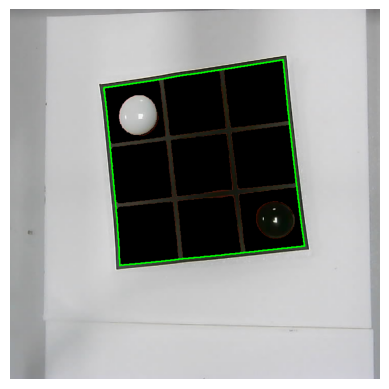

-6


In [2]:
if __name__ == "__main__":
    print(rotationdetect())
    pass